# Notes:

In this notebook, we analyze S&P 500 stock prices and fundamentals to identify potential pairs trading opportunities. The workflow involves:

1. Data Collection: Downloaded S&P 500 companies' historical prices and fundamental data.
2. Feature Engineering: Applied feature scaling to normalize data for clustering.
3. Dimensionality Reduction: Used Principal Component Analysis (PCA) to reduce feature dimensions while preserving key information.
4. Clustering with DBSCAN:
    - Grouped similar stocks into clusters based on fundamental and price data.
    - DBSCAN was chosen for its ability to detect arbitrary-shaped clusters and handle noise.

5.  Pairs Selection & Cointegration Testing:

- Within each identified cluster, stock pairs were tested for cointegration.
- Cointegrated pairs suggest potential mean-reverting relationships, making them ideal for statistical arbitrage.


Next Steps: 
- Backtest the identified pairs to evaluate trading signals.
- Optimize feature selection to improve clustering quality.
- Explore additional machine learning models (e.g., HMM, k-Means) for refining clusters.

Outcome: The analysis provides a systematic approach to discovering stock pairs with strong statistical relationships, forming the foundation for an algorithmic pairs trading strategy.

# Import the libraries

In [ ]:
# For data manipulation and statistical tools
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

# For visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

<a id='read'></a>
# Read the Data


In [ ]:
url_sp500 = 'https://raw.githubusercontent.com/Pipbytes/datasets/refs/heads/main/Time%20series/SP_500_data.csv'
url_fundamental = 'https://raw.githubusercontent.com/Pipbytes/datasets/refs/heads/main/Time%20series/fundamentals.csv'

# Read data
prices = pd.read_csv(url_sp500, index_col=0)
fundamentals = pd.read_csv(url_fundamental, index_col=0)

# ===== Compute stock returns =====
returns = prices.ffill().pct_change().dropna() # dates,features


# ===== PCA =====
# PCA with n_components equal to the desired variance
from sklearn.decomposition import PCA
desired_variance = 0.90
pca = PCA(n_components=desired_variance).fit(returns)

# Principal component vectors dataframe
pca_matrix = pca.components_ # pc_features by original_features
returns_pca = pd.DataFrame(pca_matrix.T, # transpose(pc, og) = og, pc
                           columns=["PC_" + str(i) for i in range(1, pca_matrix.shape[0]+1)],
                           index=returns.columns
                           )

# ===== Scaling =====
# Scale returns dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

returns_data_scaled = pd.DataFrame(sc.fit_transform(returns_pca),
                                   columns=returns_pca.columns,
                                   index=returns_pca.index,
                                   )

# Scale fundamentals dataset
from sklearn.preprocessing import RobustScaler
# rb = RobustScaler()
rb = StandardScaler()
fundamentals_scaled = pd.DataFrame(rb.fit_transform(fundamentals),
                                   columns=fundamentals.columns,
                                   index=fundamentals.index,
                                   )

# ===== Merging dataframe =====
X = returns_data_scaled.merge(fundamentals_scaled,
                              left_index=True,
                              right_index=True,
                              how='inner'
                              )
X.head()


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,profitMargins,revenueGrowth,returnOnEquity
A,-0.798170,0.728196,0.406469,0.193927,0.213681,-0.278796,-1.013349,0.543785,0.131408,0.958665,...,0.553283,0.453515,-0.157554,0.339460,-0.290966,-0.492390,0.365527,0.211617,-0.042825,-0.095859
AAP,-0.241226,0.217300,-0.426884,-0.650628,-0.549153,0.048669,0.476085,-0.874122,-0.377495,-1.736424,...,-0.665427,-0.123906,0.787983,-0.208829,0.146102,0.096209,-0.024483,-0.223765,-0.042644,-0.100646
AAPL,-0.835315,1.423575,0.746478,0.137382,0.506444,-0.380093,0.953738,-0.285309,-0.031109,-0.249204,...,-0.915373,-0.094916,0.371054,0.798020,-0.978784,0.425828,-0.291930,0.540782,-0.015370,0.223345
ABBV,-1.106765,0.335284,-0.303775,0.686502,0.668700,0.427830,-0.455855,0.583775,-0.562534,0.268796,...,-0.190786,-1.800684,0.078500,-0.156450,0.876616,0.419853,-1.119642,-0.033610,-0.017808,0.451740
ABC,-0.570147,0.239204,-1.115876,0.469511,0.160914,-0.011878,0.202845,1.151160,-1.252703,0.507411,...,0.456074,0.446149,0.136367,0.341768,-0.757339,-1.100775,0.115237,-0.565008,-0.060436,-0.958390


# Create Clusters

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from itertools import combinations

def create_clusters(data, eps=5, samples=3, combine_df=None):
    # Instantiate and fit model
    dbscan = DBSCAN(eps=eps, min_samples=samples).fit(data)

    # Cluster labels in range(-1, n)
    labels = dbscan.labels_

    # Determine the number of clusters (ignoring noise), range(0, n)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Create a Series mapping tickers to their cluster labels
    clustered_series_all = pd.Series(data=labels.flatten(), index=data.index) # a series of tickers by cluster_num in (-1, n)

    # Remove noise points (label = -1)
    clustered_series = clustered_series_all[clustered_series_all != -1]

    # Generate stock pairs for each cluster
    cluster_pairs = []
    stock_pairs_list = []

    for cluster in range(n_clusters_):
        # Get all tickers in the current cluster
        cluster_tickers = clustered_series[clustered_series == cluster].index

        # Generate all possible pairs of tickers in the cluster
        pairs = list(combinations(cluster_tickers, 2))

        # Append results to list
        cluster_pairs.append({
            'Cluster No.': cluster,
            'Pairs': pairs,
            'Number of Pairs': len(pairs)
        })

        if combine_df is not None:
            for stock1, stock2 in pairs:
                stock_pairs_list.append({'stock1':stock1,
                                         'stock2':stock2,
                                         'cluster':cluster})
    if combine_df is not None:
        return pd.DataFrame(stock_pairs_list)

    return pd.DataFrame(cluster_pairs)

In [ ]:
stock_pairs_df = create_clusters(X, combine_df=True)

## Unpack pairs

In [ ]:
def unpack_clusters(data, cluster_num):
    '''
    Unpack for cluster_pair_df
    '''
    pairs_df = pd.DataFrame(data.loc[cluster_num]['Pairs'],
                            columns=['stock_1', 'stock_2'])
    return pairs_df

In [ ]:
stock_pairs_df.head()

,stock1,stock2,cluster
0,AEE,AEP,0
1,AEE,ATO,0
2,AEE,AWK,0
3,AEE,CMS,0
4,AEE,D,0


# Check for cointegration

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def check_cointegration(pairs_df, price_df, significant_level=0.05):
    results = []  # List to store results

    for _, row in pairs_df.iterrows():
        stock1, stock2, cluster = row["stock1"], row["stock2"], row["cluster"]

        try:
            # Get stock price time series
            series1 = price_df[stock1].dropna()
            series2 = price_df[stock2].dropna()

            # Align time series
            common_index = series1.index.intersection(series2.index)
            y = series1.loc[common_index]
            x = series2.loc[common_index]

            if len(y) == 0 or len(x) == 0:
                results.append([stock1, stock2, cluster, None])  # Not enough data
                continue

            # OLS Regression to find hedge ratio
            x = sm.add_constant(x)  # Add intercept term
            model = sm.OLS(y, x).fit()
            hedge_ratio = model.params.iloc[-1]  # Use .iloc to avoid FutureWarning

            # Compute spread (residuals)
            residuals = y - hedge_ratio * x.iloc[:, 1]

            # ADF test on residuals
            adf_result = adfuller(residuals)
            p_value = adf_result[1]

            # Cointegrated if p-value < significant_level
            cointegrated = p_value < significant_level
            results.append([stock1, stock2, cluster, cointegrated])

        except KeyError:
            # If stock not found in price_df, return None
            results.append([stock1, stock2, cluster, None])

    # Convert results into a DataFrame
    cointegration_df = pd.DataFrame(results, columns=["stock1", "stock2", "cluster", "cointegrated"])

    return cointegration_df


In [ ]:
tradeable_pairs = check_cointegration(stock_pairs_df, prices)

In [ ]:
tradeable_pairs[tradeable_pairs['cointegrated']==True]

,stock1,stock2,cluster,cointegrated
10,AEE,LNT,0,True
17,AEP,AWK,0,True
23,AEP,ETR,0,True
27,AEP,PNW,0,True
31,ATO,AWK,0,True
33,ATO,D,0,True
40,ATO,NI,0,True
62,CMS,ETR,0,True
68,CMS,WEC,0,True
71,D,ED,0,True


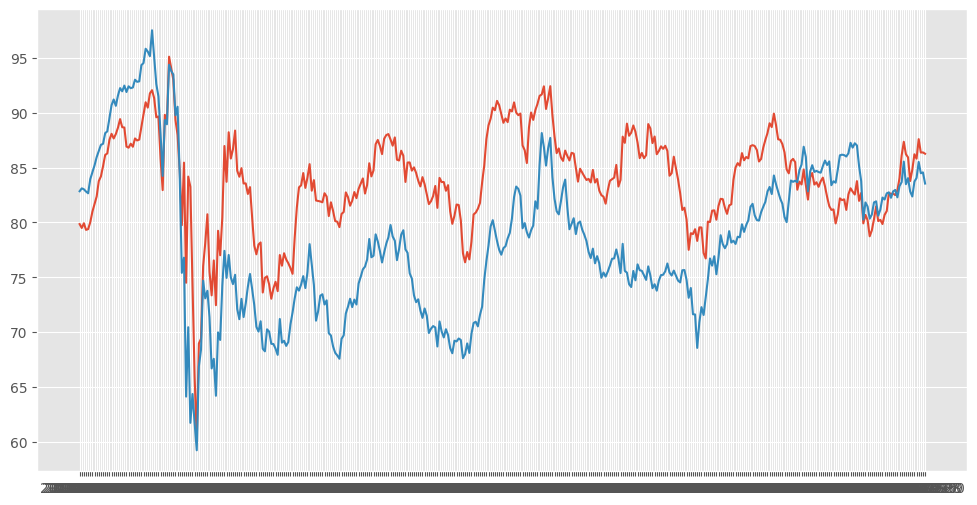

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(prices['ES'].index, prices['ES'], label='ES')
plt.plot(prices['PNW'].index, prices['PNW'], label='PNW')